In [1]:
#classify commits based on commit message text
import pandas as pd
import numpy as np 
df_c = pd.read_csv('C:/Users/Priya/Desktop/IndependentStudy/commit_text.csv')

In [20]:
df_c

,Commit message,Class
0,MODULES 2 MODULES 16 MODULES 18 MODULES 15 ...,push down
1,[java] Moving rules into correct packages acco...,move
2,Refactored ListBucketsEndpoint to use the new ...,extract
3,greatly simplified the implementation of a pip...,pull up
4,extracted jump method useful to force jump on ...,extract
...,...,...
4999,https://bugs.eclipse.org/bugs/show_bug.cgi?id ...,extract
5000,Shift further method to parent,pull up
5001,cleaning up,pull up
5002,fixed class names for changes in celements search,inline


In [2]:
#drop NA
df_c=df_c.dropna()

In [3]:
df_c

,Commit message,Class
0,extract method.,extract
1,Minor tweaks following review extraction of me...,extract
2,extract some stuff to a method[git p4: depot p...,extract
3,extract some methods in DoiServiceImpl,extract
4,refactoring getMenuSpace in Navigation: extrac...,extract
...,...,...
4999,Rename getProtocol to getMechanism in TestClient,rename
5000,Rename mapping methods to mapFrom/mapTo Signe...,rename
5001,renaming refactor on deserialization related c...,rename
5002,renamed usage to description to match the name...,rename


In [4]:
#randomie the dataset 
df_c= df_c.sample(frac=1)

In [5]:
#check the classes
df_c.Class.unique()

array(['move', 'rename', 'push down', 'extract', 'pull up', 'inline'],
      dtype=object)

In [6]:
#there are 6 classes
df_c['Class'].value_counts()

extract      834
push down    834
pull up      834
rename       834
move         834
inline       834
Name: Class, dtype: int64

In [7]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

In [8]:
import re
from nltk.corpus import stopwords

df_c = df_c.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [9]:
def clean_text(text):
    """
    function to clean commit text
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [10]:
df_c['Commit message'] = df_c['Commit message'].apply(clean_text)
df_c['Commit message'] = df_c['Commit message'].str.replace('\d+', '')

In [11]:
df_c['Commit message']

0       clustering fies refactorization gitsvnid https...
1       issue  renamed static constructor treemapmap t...
2       refactored cov build post command cov analyze ...
3       part  rename tetsource surtssource make old su...
4       renamed bridge method getrelationto getrelatio...
                              ...                        
4999    fcrepo  allow fesl relationship resolver use r...
5000    changing eventdrivers etend eventdrivers abstr...
5001    refactoring util source directory move sdktest...
5002                       checkplugincommand refactoring
5003    refactoring support remote rsa manager changei...
Name: Commit message, Length: 5004, dtype: object

In [12]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each commit
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_c['Commit message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14868 unique tokens.


In [13]:
#truncate and padding
X = tokenizer.texts_to_sequences(df_c['Commit message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5004, 100)


In [14]:
#convert classes to numbers 
Y = pd.get_dummies(df_c['Class']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5004, 6)


In [15]:
#split train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4503, 100) (4503, 6)
(501, 100) (501, 6)


In [16]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
#from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
#from gensim.models import KeyedVectors
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
 
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
64/64 [==============================] - 24s 369ms/step - loss: 1.7434 - accuracy: 0.2364 - val_loss: 1.6119 - val_accuracy: 0.3016
Epoch 2/5
64/64 [==============================] - 21s 333ms/step - loss: 1.3855 - accuracy: 0.4506 - val_loss: 1.4012 - val_accuracy: 0.4479
Epoch 3/5
64/64 [==============================] - 24s 372ms/step - loss: 1.1086 - accuracy: 0.5896 - val_loss: 1.2710 - val_accuracy: 0.4922
Epoch 4/5
64/64 [==============================] - 23s 365ms/step - loss: 0.8080 - accuracy: 0.7135 - val_loss: 1.2994 - val_accuracy: 0.5299
Epoch 5/5
64/64 [==============================] - 23s 355ms/step - loss: 0.6013 - accuracy: 0.7929 - val_loss: 1.3102 - val_accuracy: 0.5499


In [18]:
acr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acr[0],acr[1]))

16/16 [==============================] - 0s 20ms/step - loss: 1.2687 - accuracy: 0.5609
Test set
  Loss: 1.269
  Accuracy: 0.561


In [23]:
score = model.evaluate(x=[X_test], y=Y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

16/16 [==============================] - 0s 20ms/step - loss: 1.2687 - accuracy: 0.5609
Test Score: 1.2687081098556519
Test Accuracy: 0.5608782172203064


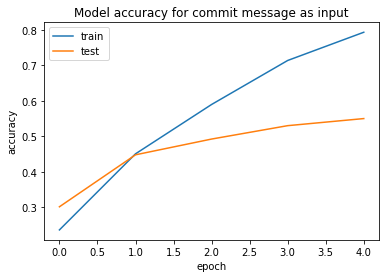

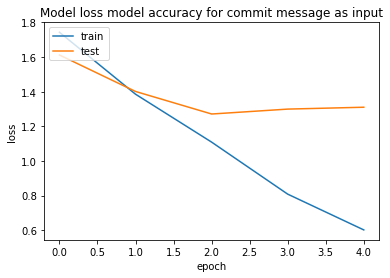

In [27]:
import matplotlib.pyplot as plt
import numpy as np # For numerical fast numerical calculations
import matplotlib.pyplot as plt # For making plots
import pandas as pd # Deals with data
import seaborn as sns # Makes beautiful plots
from sklearn.preprocessing import StandardScaler # Testing sklearn
import tensorflow # Imports tensorflow
import keras # Imports keras

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy for commit message as input')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss model accuracy for commit message as input')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()